[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/rnn/simple_rnn.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Simple Recurrent Neural Networks (RNNs) for sequence prediction

This notebook shows how to use simple RNNs to predict values on a sequence (time series). We will use a dataset containing the number of train passengers in Chicago. The data comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97/about_data). The dataset contains the  daily number of bus and train passengers from 2001 to 2021. We will use the number of train passengers as the target variable.

The dataset contains the following columns:
- `service_date`: the date of the service.
- `day_type`: the type of day (W=weekday, A=sAturday, U=sUnday).
- `bus`: the number of bus passengers.
- `rail_boardings`: the number of train passengers.
- `total_rides`: the total number of passengers.

In [14]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/deep-learning/rnn'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone --depth 1 https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.

import pandas as pd
import matplotlib.pyplot as plt
from keras import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np

Note: you may need to restart the kernel to use updated packages.


## Data preparation

 We load the dataset and preprocess it. We will use the number of train passengers as the target variable, so we remove the bus and total_rides columns. We rename the `rail_boardings` column to `rail` and the `service_date` column to `date`. We sort the dataset by date and set the date as the index of the dataframe. We also remove duplicates.

In [15]:
def load_dataset(file_name: str) -> pd.DataFrame:
    """
    Load the dataset from the CSV file
    :param file_name: the path to the CSV file
    :return: the dataset
    """
    ds = pd.read_csv(file_name, parse_dates=['service_date'])  # parse_dates converts the column to datetime
    # we will use the number of passengers for the train as the target variable, so bus and total_rides columns are not necessary
    ds = ds.drop(columns=['bus', 'total_rides'])
    # rename the rail_boardings column to rail and the service_date column to date
    ds = ds.rename(columns={"rail_boardings": "rail", "service_date": "date"})
    # remove duplicates
    ds = ds.drop_duplicates()
    # sort by date (ascending) and set the date as the index of the dataframe
    ds = ds.sort_values("date").set_index("date")
    return ds


dataset = load_dataset("data/transit.csv")
# display the first few rows of the dataset
print("First few rows of the dataset:")
print(dataset.head())

First few rows of the dataset:
           day_type    rail
date                       
2001-01-01        U  126455
2001-01-02        W  501952
2001-01-03        W  536432
2001-01-04        W  550011
2001-01-05        W  557917


Let's plot the number of train passengers for the first semester months of 2001.

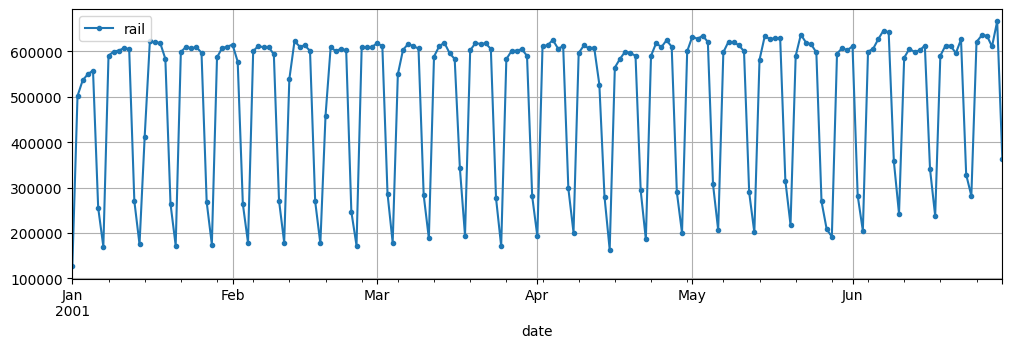

In [16]:
dataset["2001-01":"2001-06"].plot(grid=True, marker=".", figsize=(12, 3.5))
plt.show()

The default activation function for the RNN is the hyperbolic tangent (tanh) function, which outputs values between -1 and 1. A simple RNN uses the output as part of the input for the next time step. Therefore, we need to scale the data to be between -1 and 1. We use the `MinMaxScaler` from scikit-learn to scale the data. We also convert the `day_type` column to one-hot encoding.

In [17]:
def scale_data_and_convert_one_hot(dataset_p: pd.DataFrame) -> (pd.DataFrame, MinMaxScaler):
    """
    Scale the data between -1 and 1 and convert the day_type column to one-hot encoding
    :param dataset_p: the dataset
    :return: the scaled dataset
    """
    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    dataset_p['rail'] = scaler.fit_transform(dataset_p[['rail']])
    # convert the date_type column to a one-hot encoded column
    dataset_p = pd.get_dummies(dataset_p, columns=["day_type"])
    # map True to 1 and False to 0
    dataset_p = dataset_p.astype({"day_type_A": int, "day_type_U": int, "day_type_W": int})
    return dataset_p, scaler


dataset, scaler = scale_data_and_convert_one_hot(dataset)
print("First few rows of the dataset after scaling and one-hot encoding:")
print(dataset.head())

First few rows of the dataset after scaling and one-hot encoding:
                rail  day_type_A  day_type_U  day_type_W
date                                                    
2001-01-01 -0.816717           0           1           0
2001-01-02 -0.147961           0           0           1
2001-01-03 -0.086552           0           0           1
2001-01-04 -0.062368           0           0           1
2001-01-05 -0.048288           0           0           1


## Split the dataset into training, validation and test sets

We split the dataset into training, validation and test sets. We use the first 15 years of data for training, the next 3 years for validation, and the last 2 years for testing.

In [18]:
train_ds = dataset[:"2015-12"]
val_ds = dataset["2016-01":"2018-12"]
test_ds = dataset["2019-01":]

We will create a variable length time series dataset to show how RNNs can be trained with variable-length sequences. We will use a random length between 40 and 60 days for the time series X set. The target variable y will be the number of train passengers for the next day.

In [19]:
def create_variable_time_series_dataset(dataset_p: pd.DataFrame, length_from_p: int, length_to_p: int) \
        -> (list, list):
    """
    Create a variable length time series dataset
    :param dataset_p: the original dataset with the time series
    :param length_from_p: the minimum length of the time series X set
    :param length_to_p: the maximum length of the time series X set
    :return: (X, y) where X is the time series and y is the target variable
    """
    X, y = [], []
    for i in range(0, len(dataset_p)):
        series_length = np.random.randint(length_from_p, length_to_p + 1)
        if i + series_length < len(dataset_p):
            X.append(np.array(dataset_p.iloc[i:i + series_length][['rail', 'day_type_A', 'day_type_U', 'day_type_W']].values))
            y.append(dataset_p.iloc[i + series_length]['rail'])
        else:
            break
    return X, y


length_from, length_to = 40, 60
X_train, y_train = create_variable_time_series_dataset(train_ds, length_from, length_to)
X_val, y_val = create_variable_time_series_dataset(val_ds, length_from, length_to)
X_test, y_test = create_variable_time_series_dataset(test_ds, length_from, length_to)

We convert the time series X and the target variable y to TensorFlow datasets. We use the `tf.data.Dataset.from_generator`. The `output_signature` parameter specifies the shape and data type of the elements in the dataset. The time series X has shape `[None, 4]`, where `None` is for the variable sequence length, and `4` is for the number of features in each timestep. The target variable y is a scalar, show its shape is the empty tuple.

In [20]:
def X_y_to_tensor_slices(X_p: list, y_p: list) -> tf.data.Dataset:
    """
    Convert the X and y lists to a TensorFlow tf.data.Dataset
    :param X_p: the time series
    :param y_p: the target variable
    :return: the TensorFlow dataset
    """
    return tf.data.Dataset.from_generator(
        lambda: zip(X_p, y_p),
        output_signature=(
            tf.TensorSpec(shape=(None, 4), dtype=tf.float32),  # X has shape [None, 4]: None for variable sequence length, and 4 for the number of features in each timestep
            tf.TensorSpec(shape=(), dtype=tf.float32)          # y is a scalar
        )
    )

train_set_tf = X_y_to_tensor_slices(X_train, y_train)
val_set_tf = X_y_to_tensor_slices(X_val, y_val)
test_set_tf = X_y_to_tensor_slices(X_test, y_test)

We batch each sequence individually (batch of 1) to allow variable-length input (mandatory for training RNNs with variable-length sequences). The `batch` method takes a tensor ans organizes it into batches. In out case, we take a tensor with shape `[None, 4]` (variable-length of items, 4 features) and add a new dimension for the batch size (=1), so the shape becomes `[1, None, 4]`. RNNs expect the input to be a three-dimensional tensor with shape `[batch_size, sequence_length, num_features]`.

The `prefetch` method allows the next batch to be prefetched while training on the current batch (pipeline parallelism).

In [21]:
# Batch each sequence individually (batch of 1) to allow variable-length input
# (mandatory for training RNNs with variable-length sequences (not very common)).
# At inference, any length can be used, even though the model was trained with a specific length.
train_set_tf = (train_set_tf.batch(1)  # organizes the dataset into batches:
                # adds a new dimension batch-size to the dataset, grouping elements into batches
                # batch size is 1 to allow for variable length sequences
                .prefetch(1))  # prefetches the next batch while training on the current batch (pipeline parallelism)
                        # it is set to 1 to prefetch 1 batch while training on another 1 batch

val_set_tf = val_set_tf.batch(1).prefetch(1)
test_set_tf = test_set_tf.batch(1).prefetch(1)

## RNN with a single simple neuron

We create a simple RNN with a single neuron. We use Keras' `SimpleRNN`. The output is concatenated to the input (4+1=5 inputs), plus the bias, we have 6 parameters. The output is a scalar. The input shape is `[None, 4]`, where `None` is for the variable sequence length, and `4` is for the number of features in each timestep. The output is a scalar. The default activation function is the hyperbolic tangent (tanh) function.

In [22]:
simple_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 4])  # None = variable length sequence, 4 = number of features in each timestep
])
print(simple_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 1)                 6         
                                                                 
Total params: 6 (24.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


We train the model with the Huber loss function, which is less sensitive to outliers than the mean squared error and widespread for time series. We use the stochastic gradient descent (SGD) optimizer with a learning rate of 0.01 and a momentum of 0.9. We use the mean absolute error (MAE) and the mean absolute percentage error (MAPE) as metrics, which is relative measure expressed as a percentage. We use early stopping to avoid overfitting. The model is trained for 500 epochs tops.

In [23]:
def train_model(model: Model, train_set_p: tf.data.Dataset, val_set_p: tf.data.Dataset, learning_rate: float, epochs: int) \
        -> tf.keras.callbacks.History:
    # Compile the model
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    # huber loss is less is useful for time series data
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae', 'mape'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=2, restore_best_weights=True)
    history = model.fit(train_set_p, validation_data=val_set_p, epochs=epochs,
                        batch_size=1, callbacks=[early_stopping_cb])
    return history


epochs = 500
history = train_model(simple_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)

Epoch 1/500
5428/5428 [==============================] - 75s 14ms/step - loss: 0.0219 - mae: 0.1519 - mape: 303.4105 - val_loss: 0.0367 - val_mae: 0.2447 - val_mape: 97.4627
Epoch 2/500
5428/5428 [==============================] - 77s 14ms/step - loss: 0.0207 - mae: 0.1489 - mape: 318.5717 - val_loss: 0.0367 - val_mae: 0.2448 - val_mape: 97.9973
Epoch 3/500
5428/5428 [==============================] - 71s 13ms/step - loss: 0.0207 - mae: 0.1488 - mape: 320.1404 - val_loss: 0.0367 - val_mae: 0.2448 - val_mape: 98.0497


We plot the training and validation loss.

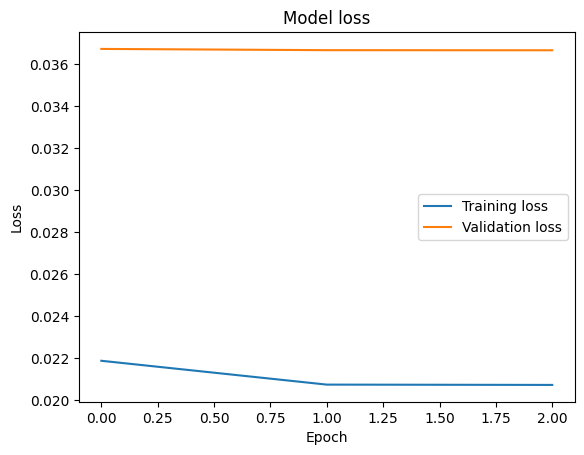

In [24]:
def plot_history(history_p: tf.keras.callbacks.History) -> None:
    """
    Plot the loss and the mean absolute error (MAE) for the training and validation sets
    :param history_p: the training history
    """
    plt.plot(history_p.history['loss'], label='Training loss')
    plt.plot(history_p.history['val_loss'], label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_history(history)

We evaluate the model on the test set. Remember that the mean absolute error (MAE) is scaled, so we need to inverse the scaling to get the actual value. That is not necessary for the mean absolute percentage error (MAPE).

In [25]:
test_loss, test_mae, test_mape = simple_model.evaluate(test_set_tf)
# The test MAE is scaled, so we need to inverse the scaling to get the actual value.
# Since the output is a 2d array (bath_size, y features), we need to select the first element of the first element of the array.
print(f"Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}.")
print(f"Test MAPE: {test_mape:.2f}.")

1011/1011 [==============================] - 5s 4ms/step - loss: 0.0659 - mae: 0.3262 - mape: 65.0331
Test MAE: 768167.
Test MAPE: 65.03.


Let's take a look at the first few predictions on the test set, to see how our model is performing.

1011/1011 [==============================] - 4s 4ms/step


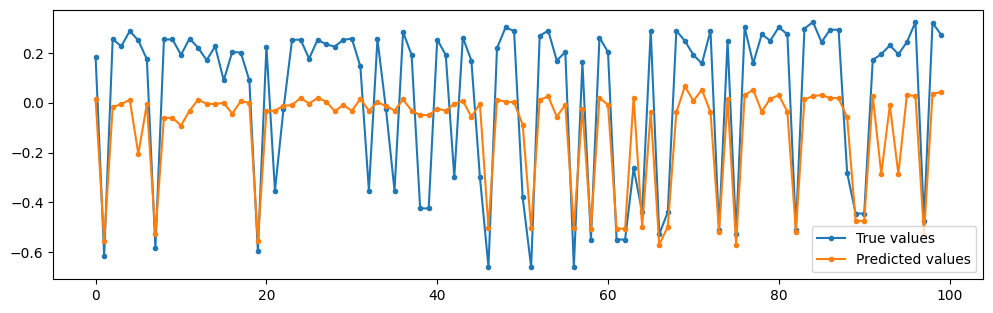

In [26]:
def plot_predictions(y_test_p: np.array, y_pred_p: np.array, n_instances: int):
    """
    Plot the first 100 instances of y_pred vs y_test
    :param y_test_p: the true values
    :param y_pred_p: the predicted values
    :param n_instances: the number of instances to plot
    """
    plt.figure(figsize=(12, 3.5))
    plt.plot(y_test_p[:n_instances], marker=".", label="True values")
    plt.plot(y_pred_p[:n_instances], marker=".", label="Predicted values")
    plt.legend()
    plt.show()


n_instances_to_plot = 100
y_pred = simple_model.predict(test_set_tf)
plot_predictions(y_test, y_pred, n_instances_to_plot)

## Multiple simple recurrent neurons

The previous model is not very accurate, but it is amazingly good for just 6 parameters. We can try to improve it by adding a layer of simple RNNs. Instead of one simple recurrent neuron, we can add 32 simple recurrent neurons to the model. Now, the output will be a 32-dimensional vector. Since the output has to be a scalar, we add a Dense layer with one neuron at the end of the model.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 32)                1184      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1217 (4.75 KB)
Trainable params: 1217 (4.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/500
5428/5428 [==============================] - 70s 13ms/step - loss: 0.0089 - mae: 0.0812 - mape: 204.3827 - val_loss: 0.0511 - val_mae: 0.2942 - val_mape: 141.1463
Epoch 2/500
5428/5428 [==============================] - 68s 12ms/step - loss: 0.0067 - mae: 0.0689 - mape: 165.5721 - val_loss: 0.0330 - val_mae: 0.2149 - val_mape: 101.3136
Epoch 3/500
5428/5428 [==============================] - 64s 12

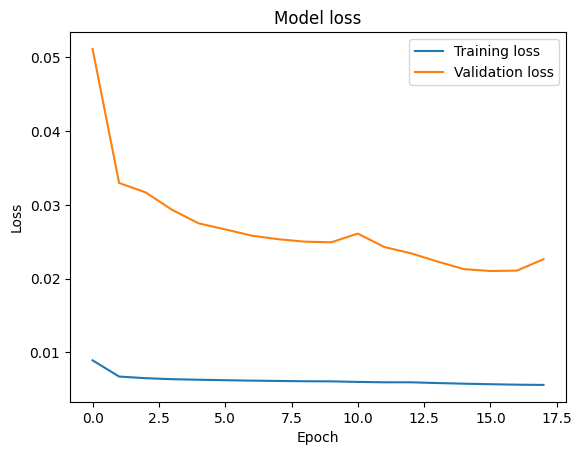

1011/1011 [==============================] - 5s 5ms/step - loss: 0.0394 - mae: 0.2039 - mape: 45.0409
Test MAE: 699500.
Test MAPE: 45.04.
1011/1011 [==============================] - 5s 5ms/step


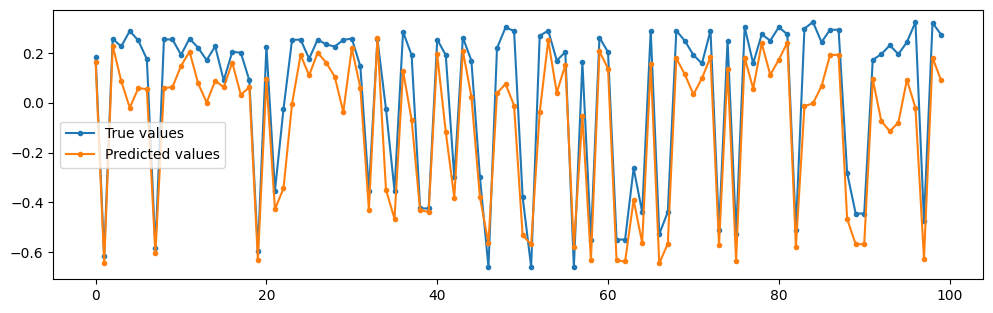

In [27]:
multi_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),  # tanh activation function by default
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print(multi_model.summary())

# train the model
history = train_model(multi_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
plot_history(history)

# evaluate the model
test_loss, test_mae, test_mape = multi_model.evaluate(test_set_tf)
print(f"Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}.")
print(f"Test MAPE: {test_mape:.2f}.")

# plot the first few predictions on the test set
y_pred = multi_model.predict(test_set_tf)
plot_predictions(y_test, y_pred, n_instances_to_plot)

## Deep RNN

We can go further in increasing the model's complexity by stacking multiple RNN layers, creating a deep RNN. We add three layers of 32 simple recurrent neurons. The output of each layer is the input of the next layer. As before, the outuput is a vector of 32 dimensions, so we add a Dense layer with one neuron at the end of the model.

*Important*: so far, a `SimpleRNN` layer returns the 32 outputs *one the sequence is finished*. That means, we do not take the outputs of all the time steps in the sequence. However, if we want to stack RNNs, we need to take the output of each time step and pass it upwards to the next layer (this is not the case for the last layer that only wants the output of the last time step). To do that, we need to set `return_sequences=True` in the `SimpleRNN` layers. This way, the output of each time step is returned, not just the last one. In this way, the next layer can process the output of each time step (they can be stacked). We use the `return_sequences=True` in the first two layers, but not in the last one.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, None, 32)          1184      
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5377 (21.00 KB)
Trainable params: 5377 (21.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/500
5428/5428 [==============================] - 222s 40ms/step - loss: 0.0140 - mae: 0.1079 - mape: 291.9186 - val_loss: 0.1047 - val_mae:

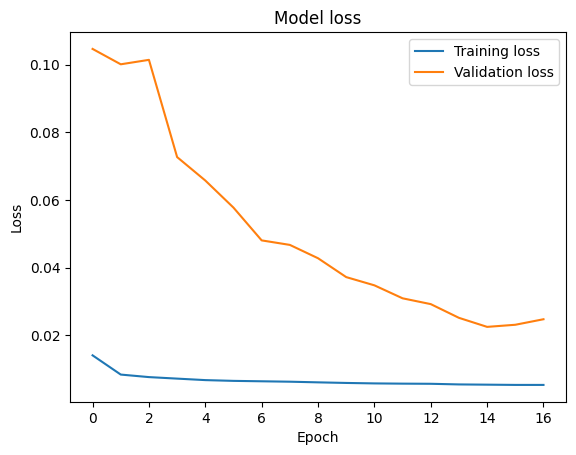

1011/1011 [==============================] - 10s 10ms/step - loss: 0.0490 - mae: 0.2480 - mape: 50.6050
Test MAE: 724283.
Test MAPE: 50.61.
1011/1011 [==============================] - 9s 9ms/step


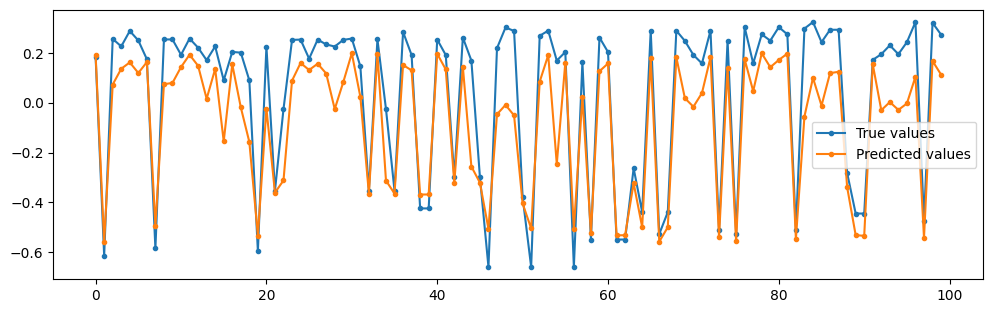

In [28]:
deep_model = tf.keras.Sequential([
    # return_sequences=True is used to return the output of each time step, not just the last one
    # in this way, the next layer can process the output of each time step (they can be stacked)
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4], return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print(deep_model.summary())

# train the model
history = train_model(deep_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
plot_history(history)

# evaluate the model
test_loss, test_mae, test_mape = deep_model.evaluate(test_set_tf)
print(f"Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}.")
print(f"Test MAPE: {test_mape:.2f}.")

# plot the first few predictions on the test set
y_pred = deep_model.predict(test_set_tf)
plot_predictions(y_test, y_pred, n_instances_to_plot)

## ✨ Questions ✨ 

1. Are model performances being improved by adding more complexity/parameters?
2. Why?
3. Do you think that will always be the case?

### Answers

*Write your answers here.*
